In [2]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram, plot_bloch_multivector, array_to_latex
from qiskit.circuit.library import Initialize
from numpy.random import randint
from qiskit.quantum_info import random_statevector

In [3]:
def create_bell_pair(qc, a, b):
    """Creates a bell pair in qc using qubits a & b"""
    qc.h(a) # Put qubit a into state |+>
    qc.cx(a,b) # CNOT with a as control and b as target

def alice_gates(qc, psi, a):
    """"psi is the qubit to be sent, a is Alice's half of Bell state"""
    qc.cx(psi, a)
    qc.h(psi)
    
def measure_and_send(qc, a, b):
    """Measures qubits a & b and 'sends' the results to Bob"""
    qc.barrier()
    qc.measure(a,0)
    qc.measure(b,1)
    
def bob_gates(qc, qubit, crz, crx):
    # Here we use c_if to control our gates with a classical
    # bit instead of a qubit
    qc.x(qubit).c_if(crx, 1) # Apply gates if the registers 
    qc.z(qubit).c_if(crz, 1) # are in the state '1'

Statevector([-0.48792571-0.06727207j, -0.81775051+0.29780375j],
            dims=(2,))


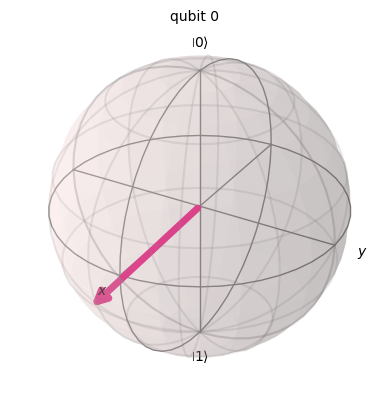

In [15]:
qr = QuantumRegister(3, name="q")    # Protocol uses 3 qubits
crz = ClassicalRegister(1, name="crz") # and 2 classical bits
crx = ClassicalRegister(1, name="crx") # in 2 different registers
qc = QuantumCircuit(qr, crz, crx)

# Create a random qubit for psi

psi = random_statevector(2)

print(psi)

# Now construct a gate to do the initialization
init_gate = Initialize(psi)
init_gate.label = "init"

# Start with our initial qubit psi
qc.append(init_gate, [0])
qc.barrier()

# Now create and entangled pair
create_bell_pair(qc, 1, 2)
qc.barrier()

# Add Alice's gates to the circuit
alice_gates(qc, 0, 1)

# Send two classical bits to Bob
measure_and_send(qc, 0, 1)

# Bob decodes the classical qubits to get the orignal qubit psi
bob_gates(qc, 2, crz, crx)

# Display the circuit
qc.draw('mpl')
plot_bloch_multivector(psi)

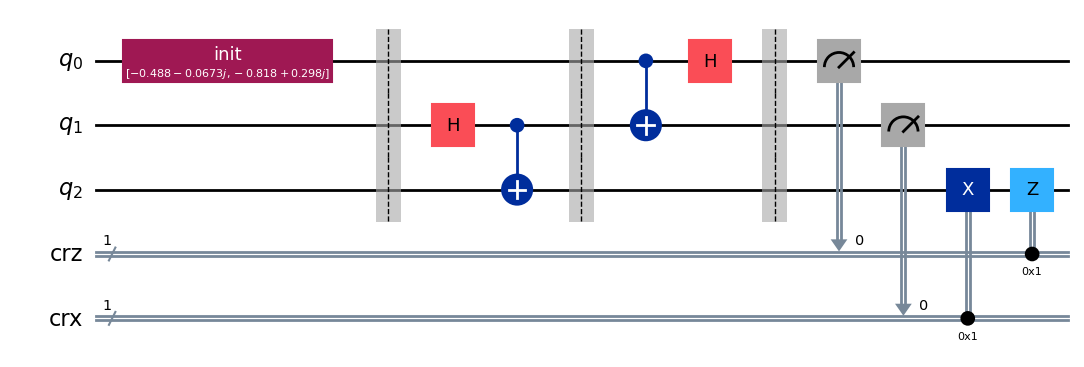

In [16]:
qc.draw('mpl')

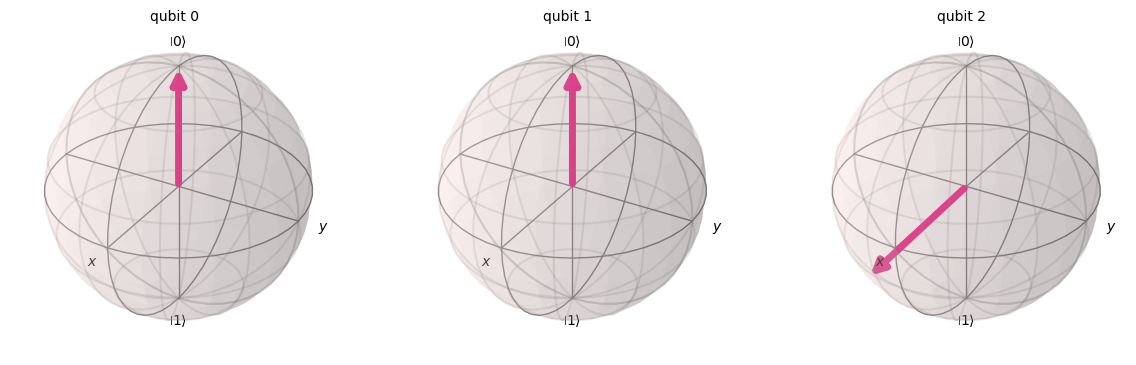

In [17]:
qc.save_statevector()
simulator = AerSimulator(method='statevector')
qcc = transpile(qc, simulator)
result = simulator.run(qcc).result()
plot_bloch_multivector(result.get_statevector())

In [7]:
# Define a function that takes a QuantumCircuit (qc)
# a qubit index (qubit) and a message string (msg)
def encode_message(qc, qubit, msg):
    if msg == "00":
        pass    # To send 00 we do nothing
    elif msg == "10":
        qc.x(qubit) # To send 10 we apply an X-gate
    elif msg == "01":
        qc.z(qubit) # To send 01 we apply a Z-gate
    elif msg == "11":
        qc.z(qubit) # To send 11, we apply a Z-gate
        qc.x(qubit) # followed by an X-gate
    else:
        print("Invalid Message: Sending '00'")
        
def decode_message(qc, a, b):
    qc.cx(a,b)
    qc.h(a)

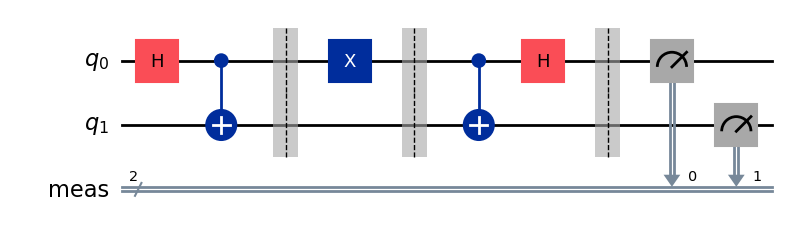

In [8]:
# Create the quantum circuit with 2 qubits
qc = QuantumCircuit(2)

# First, create the entangled pair between Alice and Bob
create_bell_pair(qc, 0, 1)
qc.barrier() 

# Next, Alice encodes her message onto qubit 0. In this case,
# we want to send the message '10'. You can try changing this
# value and see how it affects the circuit
message = "10"
encode_message(qc, 0, message)
qc.barrier()
# Alice then sends her qubit to Bob.

# After recieving qubit 0, Bob applies the recovery protocol:
decode_message(qc, 0, 1)

# Finally, Bob measures his qubits to read Alice's message
qc.measure_all()

# Draw our output
qc.draw(output = "mpl")

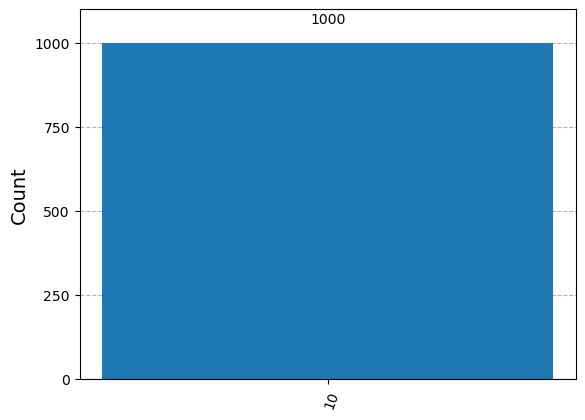

In [9]:
simulator = AerSimulator()
qcc = transpile(qc, simulator)
job = simulator.run(qcc,shots=1000)
plot_histogram(job.result().get_counts())

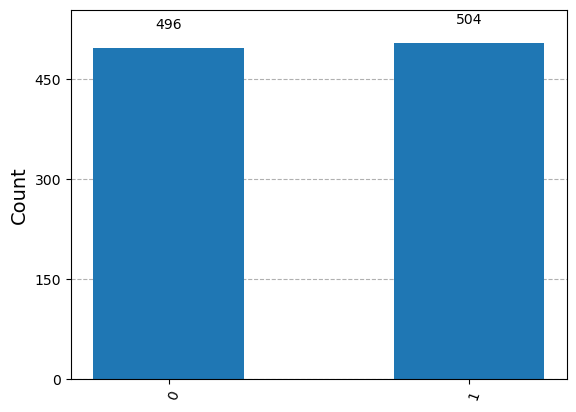

In [18]:
qc = QuantumCircuit(1,1)
qc.h(0)
qc.measure([0],[0])
simulator = AerSimulator()
qcc = transpile(qc, simulator)
job = simulator.run(qcc,shots=1000)
plot_histogram(job.result().get_counts())

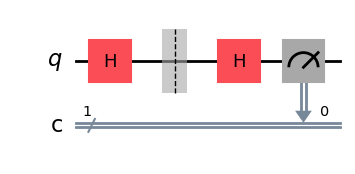

In [19]:
qc = QuantumCircuit(1,1)
# Alice prepares qubit in state |+>
qc.h(0)
qc.barrier()
# Alice now sends the qubit to Bob
# who measures it in the X-basis
qc.h(0)
qc.measure(0,0)

# Draw and simulate circuit
qc.draw('mpl')

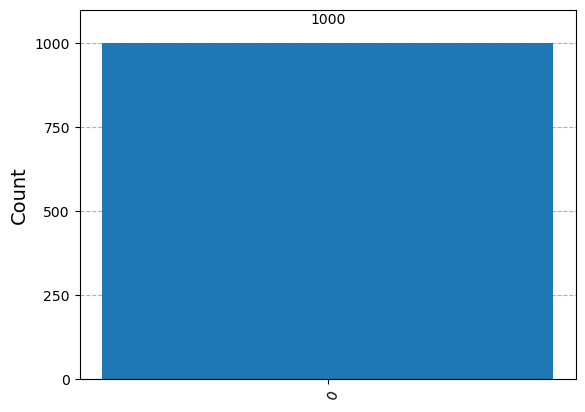

In [20]:
simulator = AerSimulator()
qcc = transpile(qc, simulator)
job = simulator.run(qcc,shots=1000)
plot_histogram(job.result().get_counts())

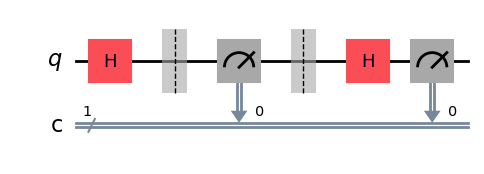

In [10]:
qc = QuantumCircuit(1,1)
# Alice prepares qubit in state |+>
qc.h(0)
qc.barrier()
# Eve intercepts the qubit, but measures in the wrong basis
qc.measure(0, 0)
qc.barrier()
# Alice now sends the qubit to Bob
# who measures it in the X-basis
qc.h(0)
qc.measure(0,0)

# Draw and simulate circuit
qc.draw('mpl')


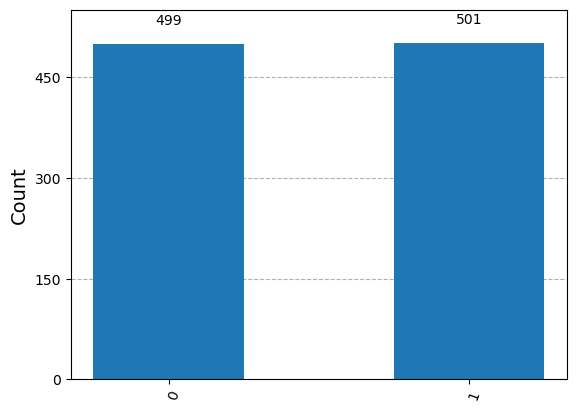

In [11]:
simulator = AerSimulator()
qcc = transpile(qc, simulator)
job = simulator.run(qcc,shots=1000)
plot_histogram(job.result().get_counts())

In [12]:
def encode_message(bits, bases):
    message = []
    for i in range(n):
        qc = QuantumCircuit(1,1)
        if bases[i] == 0: # Prepare qubit in Z-basis
            if bits[i] == 0:
                pass 
            else:
                qc.x(0)
        else: # Prepare qubit in X-basis
            if bits[i] == 0:
                qc.h(0)
            else:
                qc.x(0)
                qc.h(0)
        qc.barrier()
        message.append(qc)
    return message

def measure_message(message, bases):
    simulator = AerSimulator()
    measurements = []
    for q in range(n):
        if bases[q] == 0: # measuring in Z-basis
            message[q].measure(0,0)
        if bases[q] == 1: # measuring in X-basis
            message[q].h(0)
            message[q].measure(0,0)
        qcc = transpile(message[q], simulator)
        result = simulator.run(qcc, shots=1, memory=True).result()
        measured_bit = int(result.get_memory()[0])
        measurements.append(measured_bit)
    return measurements

def remove_garbage(a_bases, b_bases, bits):
    good_bits = []
    for q in range(n):
        if a_bases[q] == b_bases[q]:
            # If both used the same basis, add
            # this to the list of 'good' bits
            good_bits.append(bits[q])
    return good_bits

def sample_bits(bits, selection):
    sample = []
    for i in selection:
        # use np.mod to make sure the
        # bit we sample is always in 
        # the list range
        i = np.mod(i, len(bits))
        # pop(i) removes the element of the
        # list at index 'i'
        sample.append(bits.pop(i))
    return sample

In [21]:
np.random.seed(seed=3)
n = 100

## Step 1
# Alice generates bits
alice_bits = randint(2, size=n)

## Step 2
# Create an array to tell us which qubits
# are encoded in which bases
alice_bases = randint(2, size=n)
message = encode_message(alice_bits, alice_bases)

## Step 3
# Decide which basis to measure in:
bob_bases = randint(2, size=n)
bob_results = measure_message(message, bob_bases)

## Step 4
alice_key = remove_garbage(alice_bases, bob_bases, alice_bits)
bob_key = remove_garbage(alice_bases, bob_bases, bob_results)

## Step 5
sample_size = 15
bit_selection = randint(n, size=sample_size)

bob_sample = sample_bits(bob_key, bit_selection)
print("  bob_sample = " + str(bob_sample))
alice_sample = sample_bits(alice_key, bit_selection)
print("alice_sample = "+ str(alice_sample))
if bob_sample == alice_sample:
    print("key is safe")
else:
    print("key is compromized")
print("Efficiency: "+str(len(bob_key)/n))

  bob_sample = [0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1]
alice_sample = [0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1]
key is safe
Efficiency: 0.32


In [22]:
np.random.seed(seed=3)
n = 100

## Step 1
# Alice generates bits
alice_bits = randint(2, size=n)

## Step 2
# Create an array to tell us which qubits
# are encoded in which bases
alice_bases = randint(2, size=n)
message = encode_message(alice_bits, alice_bases)

# DANGER, DANGER, DANGER !!!
# Eve has intercepted the message
eve_bases = randint(2, size=n)
intercepted_message = measure_message(message, eve_bases)

## Step 3
# Decide which basis to measure in:
bob_bases = randint(2, size=n)
bob_results = measure_message(message, bob_bases)

## Step 4
alice_key = remove_garbage(alice_bases, bob_bases, alice_bits)
bob_key = remove_garbage(alice_bases, bob_bases, bob_results)

## Step 5
sample_size = 15
bit_selection = randint(n, size=sample_size)

bob_sample = sample_bits(bob_key, bit_selection)
print("  bob_sample = " + str(bob_sample))
alice_sample = sample_bits(alice_key, bit_selection)
print("alice_sample = "+ str(alice_sample))
if bob_sample == alice_sample:
    print("key is safe")
else:
    print("key is compromized")
print("Efficiency: "+str(len(bob_key)/n))

  bob_sample = [1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1]
alice_sample = [1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
key is compromized
Efficiency: 0.37
